In [ ]:
!pip install -q tensorflow matplotlib


In [ ]:
# Cat and Dog Image Classifier - Google Colab ready
# Follow the cell comments (Cell 1, Cell 2, ...) when copying into Colab.


# ------------------- Cell 1: Imports -------------------
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# ------------------- Cell 2: Download + unzip dataset -------------------

import os, zipfile

# Download dataset (Cats vs Dogs)
DATA_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_path = "/content/cats_and_dogs_filtered.zip"

# Only download if not already present
if not os.path.exists("/content/cats_and_dogs_filtered"):
    !wget -q --show-progress $DATA_URL -O $zip_path
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("/content/")

# Set directory paths
base_dir = "/content/cats_and_dogs_filtered"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")

# Print to confirm
print("Base directory:", base_dir)
print("Train directory:", train_dir)
print("Validation directory:", validation_dir)

# Optional — create a small test folder (for challenge-style tests)
import shutil

test_dir = os.path.join(base_dir, "test")
if not os.path.exists(test_dir):
    os.makedirs(os.path.join(test_dir, "unknown"), exist_ok=True)
    val_cats = os.listdir(os.path.join(validation_dir, "cats"))
    val_dogs = os.listdir(os.path.join(validation_dir, "dogs"))
    for fname in val_cats[:25]:
        shutil.copy(os.path.join(validation_dir, "cats", fname),
                    os.path.join(test_dir, "unknown", "cat_" + fname))
    for fname in val_dogs[:25]:
        shutil.copy(os.path.join(validation_dir, "dogs", fname),
                    os.path.join(test_dir, "unknown", "dog_" + fname))

print("Test directory ready:", test_dir)


/content/cats_and_d 100%[===================>]  65.43M   150MB/s    in 0.4s    
Base directory: /content/cats_and_dogs_filtered
Train directory: /content/cats_and_dogs_filtered/train
Validation directory: /content/cats_and_dogs_filtered/validation
Test directory ready: /content/cats_and_dogs_filtered/test


In [ ]:
# ---------------- Fix / Create test folder ----------------
import os, shutil

test_dir = os.path.join(base_dir, "test")
unknown_dir = os.path.join(test_dir, "unknown")

if not os.path.exists(unknown_dir):
    os.makedirs(unknown_dir, exist_ok=True)
    val_cats = os.listdir(os.path.join(validation_dir, "cats"))
    val_dogs = os.listdir(os.path.join(validation_dir, "dogs"))

    # Copy 25 cats + 25 dogs to make 50 test images
    for fname in val_cats[:25]:
        shutil.copy(os.path.join(validation_dir, "cats", fname),
                    os.path.join(unknown_dir, "cat_" + fname))
    for fname in val_dogs[:25]:
        shutil.copy(os.path.join(validation_dir, "dogs", fname),
                    os.path.join(unknown_dir, "dog_" + fname))

print("✅ Test folder created at:", test_dir)
print("Contains", len(os.listdir(unknown_dir)), "test images.")


✅ Test folder created at: /content/cats_and_dogs_filtered/test
Contains 50 test images.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# ✅ Base directory
base_dir = "/content/cats_and_dogs_filtered"

# ✅ Parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# ✅ Folder paths
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# ✅ Generators
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


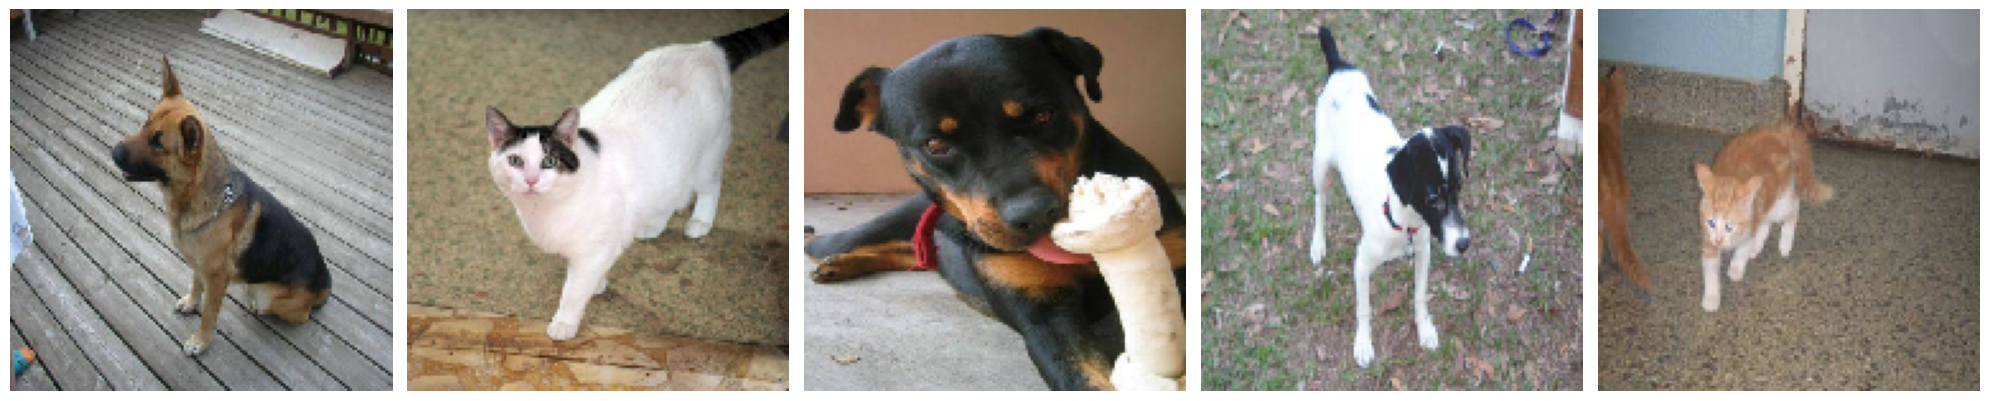

In [ ]:
# ------------------- Cell 4: Visualize Training Images -------------------
import numpy as np
import matplotlib.pyplot as plt

def plotImages(images_arr, probs=None):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        if probs is not None:
            title = f"{probs:.2f}"
            ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Get a batch of training images
sample_training_images, _ = next(train_data_gen)

# Plot the images
plotImages(sample_training_images[:5])


In [ ]:
# ------------------- Cell 5: Data Augmentation -------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a new ImageDataGenerator for training with augmentation
train_image_generator = ImageDataGenerator(
    rescale=1.0/255,         # normalize pixel values
    rotation_range=40,       # randomly rotate images
    width_shift_range=0.2,   # shift width
    height_shift_range=0.2,  # shift height
    shear_range=0.2,         # shear transformation
    zoom_range=0.2,          # random zoom
    horizontal_flip=True,    # flip images horizontally
    fill_mode='nearest'      # fill missing pixels after transformation
)

# Recreate the training generator using augmented images
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    shuffle=True
)

print("✅ Data augmentation setup complete.")


Found 2000 images belonging to 2 classes.
✅ Data augmentation setup complete.


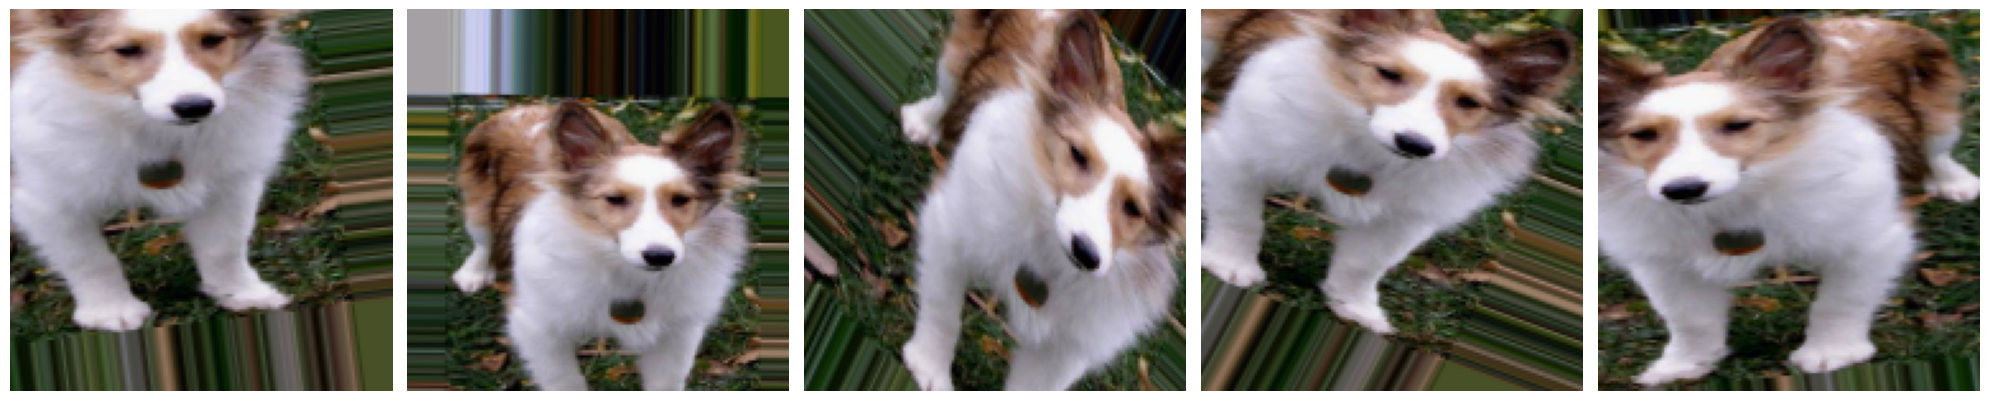

In [ ]:
# ------------------- Cell 6: Visualize Augmented Images -------------------
import numpy as np
import matplotlib.pyplot as plt

# Pick one sample image from the training generator
sample_training_images, _ = next(train_data_gen)

# Plot 5 augmented versions of the same image
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Take one image and generate augmented versions
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)


In [ ]:
# ✅ Step 1: Define constants again
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Image settings
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # 1️⃣ First convolutional block
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(2, 2),

    # 2️⃣ Second convolutional block
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # 3️⃣ Third convolutional block
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # 4️⃣ Flatten + dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification (cat vs dog)
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Correct base directory (matches your unzip output)
base_dir = '/content/cats_and_dogs_filtered'

# Define subdirectories
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')

# Create test folder if it doesn't exist
test_dir = os.path.join(base_dir, 'test')
unknown_dir = os.path.join(test_dir, 'unknown')
os.makedirs(unknown_dir, exist_ok=True)

# Move 50 random test images if not already done
if len(os.listdir(unknown_dir)) == 0:
    import shutil, random
    cat_imgs = [os.path.join(val_dir, 'cats', f) for f in os.listdir(os.path.join(val_dir, 'cats'))][:25]
    dog_imgs = [os.path.join(val_dir, 'dogs', f) for f in os.listdir(os.path.join(val_dir, 'dogs'))][:25]
    for img in cat_imgs + dog_imgs:
        shutil.copy(img, unknown_dir)
    print("✅ Test images created.")
else:
    print("✅ Test folder already exists.")

# Image size and batch size
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32

# ✅ Image generators (rescale only)
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# ✅ Create generators
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode=None,
    shuffle=False
)


✅ Test folder already exists.
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [ ]:
EPOCHS = 5  # or 10 if you want longer training

history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // BATCH_SIZE
)

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.4765 - loss: 0.9823 - val_accuracy: 0.5020 - val_loss: 0.6922
Epoch 2/5
 1/62 ━━━━━━━━━━━━━━━━━━━━ 1:30 1s/step - accuracy: 0.6562 - loss: 0.6714

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


62/62 ━━━━━━━━━━━━━━━━━━━━ 20s 311ms/step - accuracy: 0.6562 - loss: 0.6714 - val_accuracy: 0.4990 - val_loss: 0.6958
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.5415 - loss: 0.6897 - val_accuracy: 0.5060 - val_loss: 0.6902
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.5312 - loss: 0.6969 - val_accuracy: 0.5111 - val_loss: 0.6895
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.5695 - loss: 0.6803 - val_accuracy: 0.5383 - val_loss: 0.6778


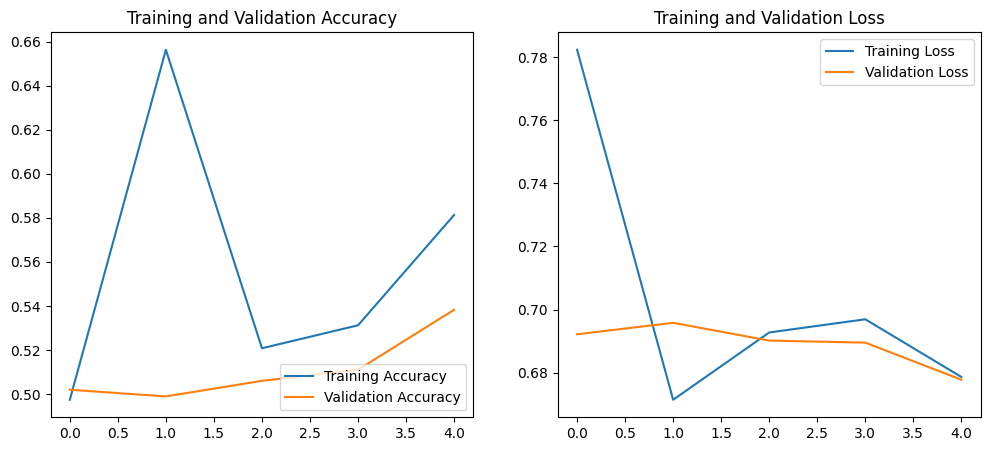

In [ ]:
# ------------------- Cell 9: Plot Training and Validation Results -------------------
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


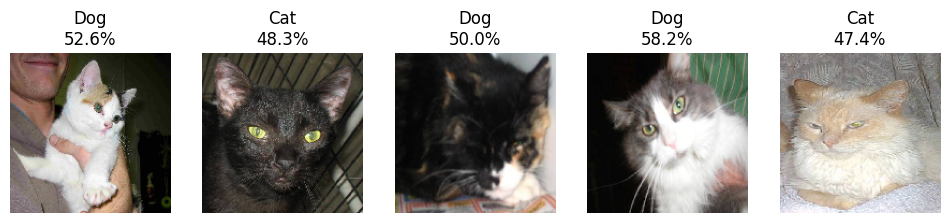

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get 5 test images
test_images = []
for i in range(5):
    img = next(test_data_gen)
    test_images.append(img[0])  # take the image (not batch)
test_images = np.array(test_images)

# Predict on these 5 images
probabilities = model.predict(test_images)
probabilities = probabilities.flatten()  # make 1D array

# Plot function
def plotImagesWithProbs(images_arr, probs):
    plt.figure(figsize=(12, 4))
    for i in range(len(images_arr)):
        plt.subplot(1, len(images_arr), i + 1)
        plt.imshow(images_arr[i])
        plt.axis('off')
        label = "Dog" if probs[i] > 0.5 else "Cat"
        plt.title(f"{label}\n{probs[i]*100:.1f}%")
    plt.show()

# Show 5 sample predictions
plotImagesWithProbs(test_images, probabilities)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


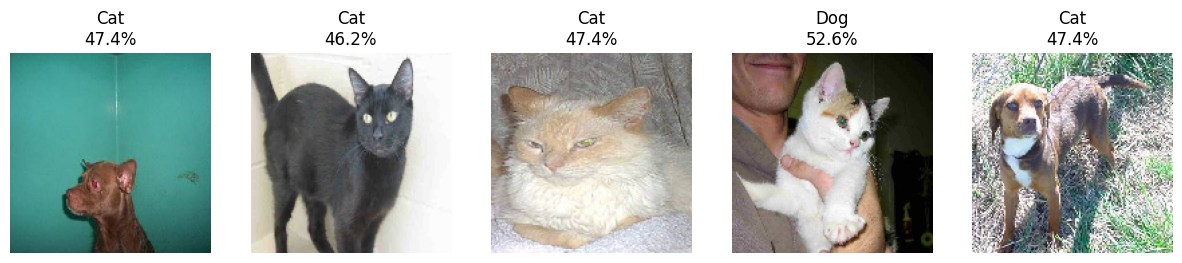

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Reset generator to start from beginning
test_data_gen.reset()

# Get all test images
test_images = []
for i in range(len(test_data_gen)):
    img_batch = next(test_data_gen)
    for img in img_batch:
        test_images.append(img)
test_images = np.array(test_images)

# Predict probabilities
probabilities = model.predict(test_images)
probabilities = probabilities.flatten()

# Pick 5 random indices
random_indices = random.sample(range(len(test_images)), 5)

# Plot function for 5 images
def plotRandomTestImages(images, probs, indices):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
        label = "Dog" if probs[idx] > 0.5 else "Cat"
        plt.title(f"{label}\n{probs[idx]*100:.1f}%")
    plt.show()

# Plot 5 random test images
plotRandomTestImages(test_images, probabilities, random_indices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


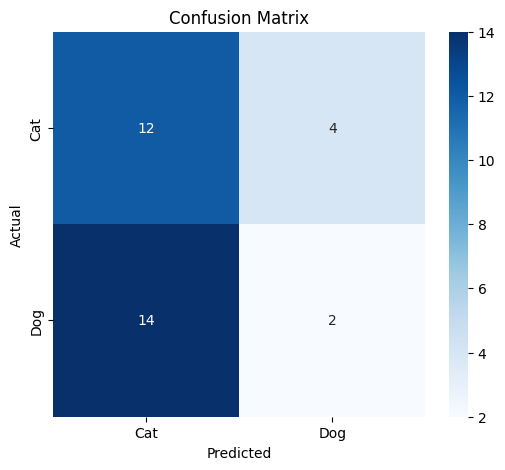

Classification Report:
               precision    recall  f1-score   support

         Cat       0.46      0.75      0.57        16
         Dog       0.33      0.12      0.18        16

    accuracy                           0.44        32
   macro avg       0.40      0.44      0.38        32
weighted avg       0.40      0.44      0.38        32



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Reset test generator
test_data_gen.reset()

# Get all test images and labels
# For this, we will create a proper labeled test generator (from validation images or manually)
# Assuming test images are unlabeled, we can use validation set for metrics

# Predict on validation set
val_data_gen.reset()
val_images, val_labels = next(val_data_gen)  # batch of validation
# Or iterate over full validation set if you want complete evaluation
val_predictions = model.predict(val_images)
val_predictions = (val_predictions > 0.5).astype(int).flatten()

# True labels
true_labels = val_labels.astype(int)

# Confusion matrix
cm = confusion_matrix(true_labels, val_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
cr = classification_report(true_labels, val_predictions, target_names=['Cat', 'Dog'])
print("Classification Report:\n", cr)
